In [1]:
import torch, numpy as np, matplotlib.pyplot as plt
from torchvision.transforms import v2
from multitask.framework1.multiscale_fusion import StandardMultiScaleFusion
from multitask.framework1.model import MultiTaskFaceAnalysisModel
from backbones.backbones import get_backbone
import datasets as db
from multitask.framework1.subnets import FaceRecognitionEmbeddingSubnet, AgeEstimationSubnet, GenderRecognitionSubnet, EmotionRecognitionSubnet, RaceRecognitionSubnet, AttributeRecognitionSubnet, PoseEstimationSubnet

/home/thoal/anaconda3/envs/pytorch/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
test_transform = v2.Compose([ # for testing on datasets other than face recognition.
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
dataset = db.CelebA()

In [4]:
image, label = dataset[0]

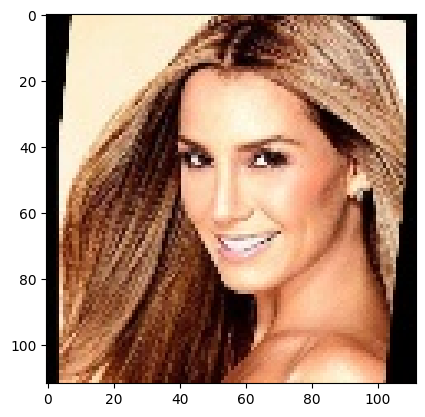

In [5]:
plt.imshow(image.permute(1, 2, 0))

In [6]:
dataset.labels_df['split'].unique()

array(['train', 'validation'], dtype=object)

In [7]:
weights = dataset.get_sample_weights()
unique_weights, counts = np.unique(weights, return_counts = True)
summation = sum(weights)
print(unique_weights, counts)
print(summation)

[5.47537178e-06] [182636]
1.0000000000013187


In [8]:
len(dataset.labels_df)

182636